**XÂY DỰNG MÔ HÌNH CVAE CHO TỔNG HỢP TÍN HIỆU PPG**

**Người thực hiện: Nguyễn Hoàng Phúc**

## Gộp dữ liệu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from scipy.signal import butter, filtfilt
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks


In [2]:


# Đường dẫn thư mục dữ liệu gốc và thư mục lưu kết quả
input_folder = r"data/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc_csv"
output_folder = r"filtered_data"
subj_ids = []
subj_folders = []

# Tạo thư mục processed_data nếu chưa tồn tại
os.makedirs(output_folder, exist_ok=True)
filtered_person_count = 0
# Số lượng người: 01 đến 53
for i in range(1, 54):
    full_filtered = True

    # Định dạng số với 2 chữ số
    subj_id = f"{i:02d}"
    subj_ids.append(subj_id)

    # Tạo thư mục con cho mỗi người
    subj_folder = os.path.join(output_folder, f"bidmc_{subj_id}")
    os.makedirs(subj_folder, exist_ok=True)
    subj_folders.append(subj_folder)
    
    # Đường dẫn file
    signals_file = os.path.join(input_folder, f"bidmc_{subj_id}_Signals.csv")
    numerics_file = os.path.join(input_folder, f"bidmc_{subj_id}_Numerics.csv")
    breaths_file = os.path.join(input_folder, f"bidmc_{subj_id}_Breaths.csv")
    
    # 1. Đọc và trích xuất từ Signals: chỉ lấy cột "Time [s]" và "PLETH"
    if os.path.exists(signals_file):
        df_signals = pd.read_csv(signals_file)
        df_signals.columns = df_signals.columns.str.strip()
        # Kiểm tra và lấy đúng tên cột (nếu có khoảng trắng, ...)
        if 'Time [s]' in df_signals.columns and 'PLETH' in df_signals.columns:
            df_signals = df_signals[['Time [s]', 'PLETH']]
        else:
            # Nếu không tìm thấy cột nào, đánh dấu là không đầy đủ
            full_filtered = False
        # Lưu file đã xử lý
        df_signals.to_csv(os.path.join(subj_folder, "Signals_filtered.csv"), index=False)
    
    # 2. Đọc và trích xuất từ Numerics: lấy cột "Time [s]", "HR" và "RESP"
    if os.path.exists(numerics_file):
        df_numerics = pd.read_csv(numerics_file)
        df_numerics.columns = df_numerics.columns.str.strip()

        # Kiểm tra và lấy đúng tên cột (nếu có khoảng trắng, ...)
        if 'Time [s]' in df_numerics.columns and 'HR' in df_numerics.columns and 'RESP' in df_numerics.columns:
            df_numerics = df_numerics[['Time [s]', 'HR', 'RESP']]
        else:
            # Nếu không tìm thấy cột nào, đánh dấu là không đầy đủ
            full_filtered = False

        # Lưu file đã xử lý
        df_numerics.to_csv(os.path.join(subj_folder, "Numerics_filtered.csv"), index=False)
    
    # 3. Đọc và trích xuất từ Breath: chọn cột annotator (ví dụ: đặt lại tên thành "ann1", "ann2")
    if os.path.exists(breaths_file):
        df_breaths = pd.read_csv(breaths_file)
        df_breaths.columns = df_breaths.columns.str.strip()
        # Kiểm tra và lấy đúng tên cột (nếu có khoảng trắng, ...)
        if 'breaths ann1 [signal sample no]' in df_breaths.columns and 'breaths ann2 [signal sample no]' in df_breaths.columns:
            # Đổi tên cột cho dễ đọc
            rename_dict = {}
            for col in df_breaths.columns:
                if "ann1" in col.lower():
                    rename_dict[col] = "ann1"
                elif "ann2" in col.lower():
                    rename_dict[col] = "ann2"
            if rename_dict:
                df_breaths.rename(columns=rename_dict, inplace=True)

            df_breaths = df_breaths[['ann1', 'ann2']]
        else:
            # Nếu không tìm thấy cột nào, đánh dấu là không đầy đủ
            full_filtered = False
        # Giả sử tên cột ban đầu là "breaths ann1 [signal sample no]" và "breaths ann2 [signal sample no]"
        
        # Lưu file đã xử lý
        df_breaths.to_csv(os.path.join(subj_folder, "Breaths_filtered.csv"), index=False)
    if not full_filtered:
        print(f"Không đúng tên cột hoặc không đủ dữ liệu dữ liệu cho người {subj_id}. Bỏ qua.")
        continue
    filtered_person_count += 1

# Thông báo đã xử lý xong một người
print(f"Đã xử lý dữ liệu cho {filtered_person_count} người.")


Đã xử lý dữ liệu cho 53 người.


## Xử lý các dữ liệu thiếu hoặc sai

In [3]:
# Sau khi xử lý xong, ta sẽ làm sạch dữ liệu trong các file đã lưu trong thư mục filtered_data
print("Bắt đầu làm sạch dữ liệu...")

# Sau khi lưu dữ liệu, ta load lại dữ liệu từ filtered_data để xử lý các giá trị null hoặc không hợp lệ
# Ví dụ: điền giá trị bị thiếu (fillna) với phương pháp forward fill, và sau đó loại bỏ nếu vẫn còn null.
def clean_dataframe(df, method='ffill'):
    # Áp dụng forward fill
    # df_clean = df.fillna(method=method)
    if method == 'ffill':
        df_clean = df.ffill()
    elif method == 'bfill':
        df_clean = df.bfill()
    else:
        raise ValueError("Chỉ hỗ trợ 'ffill' hoặc 'bfill'")
    # Nếu vẫn còn null, loại bỏ các dòng chứa null
    df_clean = df_clean.dropna()
    return df_clean

# Duyệt qua từng thư mục con và làm sạch dữ liệu
for subj in os.listdir(output_folder):
    subj_path = os.path.join(output_folder, subj)
    if os.path.isdir(subj_path):
        # Danh sách file đã xử lý trong thư mục của người đó
        for file_name in os.listdir(subj_path):
            if file_name.endswith("_filtered.csv"):
                file_path = os.path.join(subj_path, file_name)
                df = pd.read_csv(file_path)
                df_clean = clean_dataframe(df)
                # Lưu lại file sau khi làm sạch (có thể ghi đè file cũ)
                df_clean.to_csv(file_path, index=False)
                
print(f"Đã trích xuất và làm sạch dữ liệu vào thư mục '{output_folder}'.")

Bắt đầu làm sạch dữ liệu...
Đã trích xuất và làm sạch dữ liệu vào thư mục 'filtered_data'.


## Xem dữ liệu

In [4]:

def plot_pleth_with_breaths(df_signals, df_breaths, duration=30, fs=125):
    """
    Vẽ tín hiệu PLETH với breath annotations trong khoảng thời gian từ 0 đến duration giây.
    
    Parameters:
    - df_signals (pd.DataFrame): Dataframe chứa cột 'Time [s]' và 'PLETH'.
    - df_breaths (pd.DataFrame): Dataframe chứa cột 'ann1' và 'ann2' (sample numbers).
    - duration (float): Độ dài đoạn tín hiệu cần vẽ (mặc định: 30 giây).
    - fs (float): Tần số lấy mẫu (mặc định: 125 Hz).
    """
    # Lọc đoạn tín hiệu PLETH từ 0 đến duration giây
    pleth_segment = df_signals[df_signals['Time [s]'] <= duration]
    
    # Xác định các nhịp thở hợp lệ trong phạm vi tín hiệu
    max_sample = len(df_signals) - 1
    valid_ann1 = df_breaths['ann1'][df_breaths['ann1'] <= max_sample]
    valid_ann2 = df_breaths['ann2'][df_breaths['ann2'] <= max_sample]
    
    # Chuyển sample number thành thời gian và lọc trong khoảng 0-duration
    breath_times_ann1 = df_signals['Time [s]'].iloc[valid_ann1]
    breath_times_ann1_segment = breath_times_ann1[breath_times_ann1 <= duration]
    
    breath_times_ann2 = df_signals['Time [s]'].iloc[valid_ann2]
    breath_times_ann2_segment = breath_times_ann2[breath_times_ann2 <= duration]
    
    # Vẽ biểu đồ
    plt.figure(figsize=(12, 4))
    plt.plot(pleth_segment['Time [s]'], pleth_segment['PLETH'], label='PLETH', color='black')
    plt.vlines(breath_times_ann1_segment, ymin=pleth_segment['PLETH'].min(), 
               ymax=pleth_segment['PLETH'].max(), colors='blue', linestyles='solid', label='Ann1')
    plt.vlines(breath_times_ann2_segment, ymin=pleth_segment['PLETH'].min(), 
               ymax=pleth_segment['PLETH'].max(), colors='red', linestyles='dashed', label='Ann2')
    plt.xlabel('Thời gian (giây)')
    plt.ylabel('PLETH')
    plt.legend()
    plt.title(f'Tín hiệu PLETH với nhịp thở (0-{duration} giây)')
    plt.grid(True)
    plt.show()

def plot_hr_resp(df_numerics):
    """
    Vẽ biểu đồ HR và RESP từ dataframe Numerics.
    
    Parameters:
    - df_numerics (pd.DataFrame): Dataframe chứa cột 'Time [s]', 'HR', và 'RESP'.
    """
    plt.figure(figsize=(12, 4))
    ax = plt.gca()
    
    # Vẽ HR trên trục y chính
    ax.plot(df_numerics['Time [s]'], df_numerics['HR'], color='green', label='HR')
    ax.set_xlabel('Thời gian (giây)')
    ax.set_ylabel('HR (nhịp/phút)', color='green')
    ax.tick_params(axis='y', labelcolor='green')
    
    # Vẽ RESP trên trục y thứ hai
    ax_r = ax.twinx()
    ax_r.plot(df_numerics['Time [s]'], df_numerics['RESP'], color='purple', label='RESP')
    ax_r.set_ylabel('RESP (nhịp/phút)', color='purple')
    ax_r.tick_params(axis='y', labelcolor='purple')
    
    # Thêm legend
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax_r.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc='upper left')
    
    plt.title('Nhịp tim (HR) và Nhịp thở (RESP)')
    plt.grid(True)
    plt.show()

def plot_frequency_spectrum(df_signals, duration=30, fs=125):
    """
    Vẽ phổ tần số của tín hiệu PLETH trong khoảng thời gian từ 0 đến duration giây.
    
    Parameters:
    - df_signals (pd.DataFrame): Dataframe chứa cột 'Time [s]' và 'PLETH'.
    - duration (float): Độ dài đoạn tín hiệu cần phân tích (mặc định: 30 giây).
    - fs (float): Tần số lấy mẫu (mặc định: 125 Hz).
    """
    # Lọc đoạn tín hiệu PLETH từ 0 đến duration giây
    pleth_segment = df_signals[df_signals['Time [s]'] <= duration]
    
    # Tính phổ tần số
    signal = pleth_segment['PLETH'].values
    n = len(signal)
    yf = fft(signal)
    xf = fftfreq(n, 1/fs)[:n//2]
    power_spectrum = 2.0/n * np.abs(yf[0:n//2])
    
    # Tìm các đỉnh trong phổ tần số
    peaks, _ = find_peaks(power_spectrum, height=np.max(power_spectrum)*0.1)
    peak_freqs = xf[peaks]
    peak_values = power_spectrum[peaks]
    
    # Vẽ biểu đồ
    plt.figure(figsize=(12, 4))
    plt.plot(xf, power_spectrum, 'r-', label='Power Spectrum')
    plt.plot(peak_freqs, peak_values, "x", label='Peaks')
    for freq, val in zip(peak_freqs, peak_values):
        plt.annotate(f'{freq:.2f} Hz', (freq, val), xytext=(5, 5), textcoords='offset points')
    plt.xlabel('Tần số (Hz)')
    plt.ylabel('Power')
    plt.xlim(0, 5)  # Giới hạn trục x từ 0-5 Hz
    plt.title(f'Phổ tần số của PLETH (0-{duration} giây)')
    plt.legend()
    plt.grid(True)
    plt.show()



Trực quan hóa dữ liệu cho filtered_data\bidmc_14


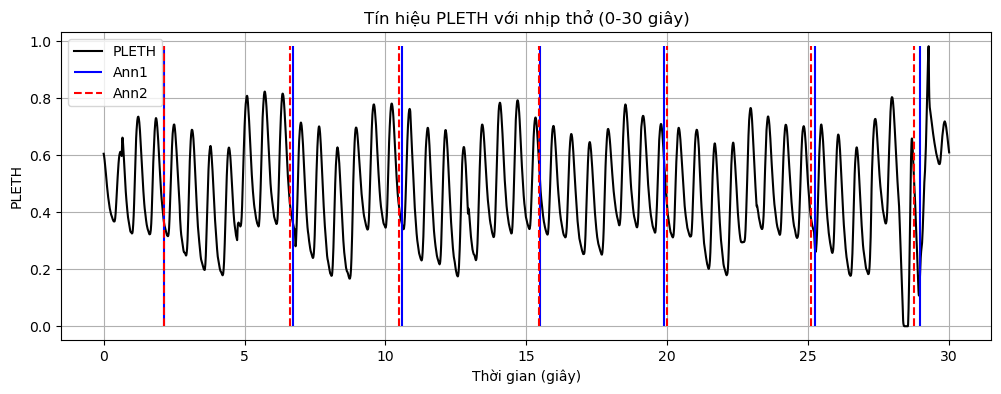

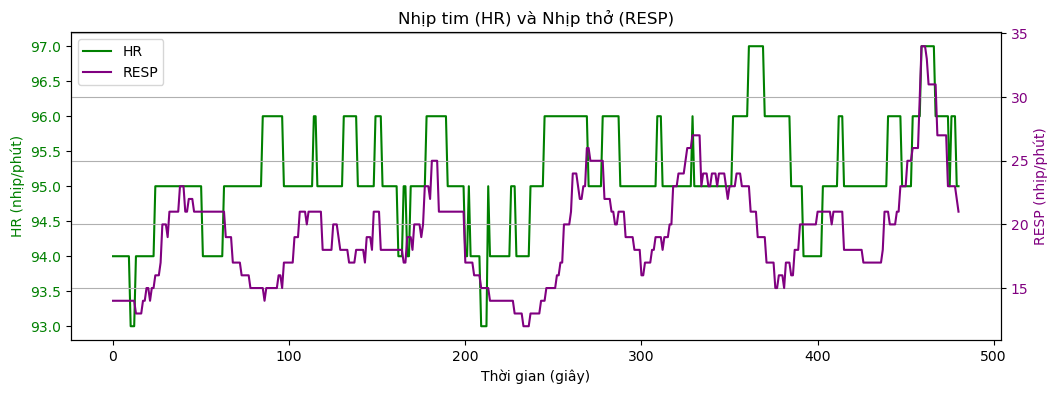

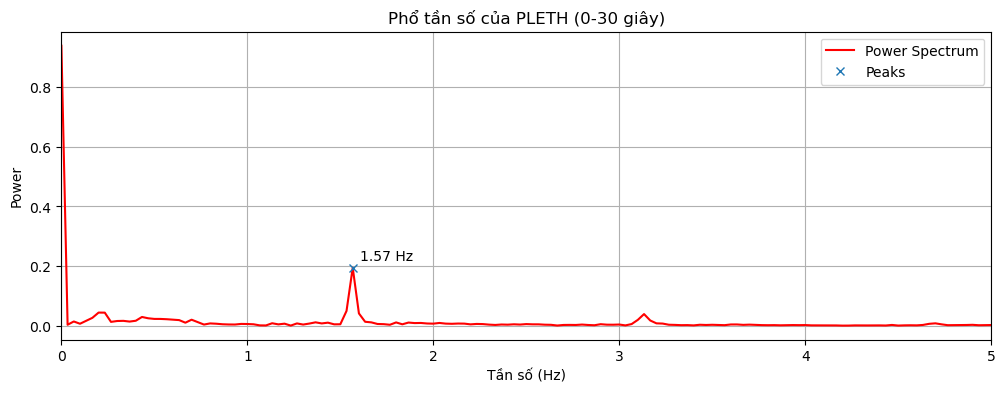

Trực quan hóa dữ liệu cho filtered_data\bidmc_46


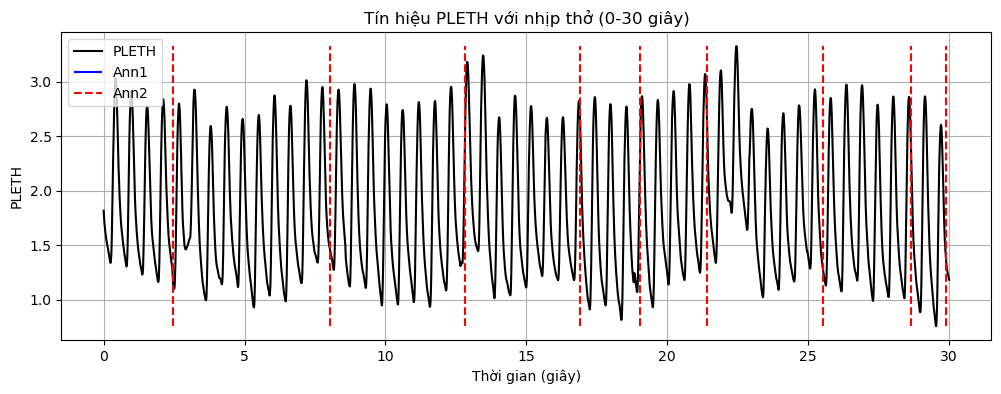

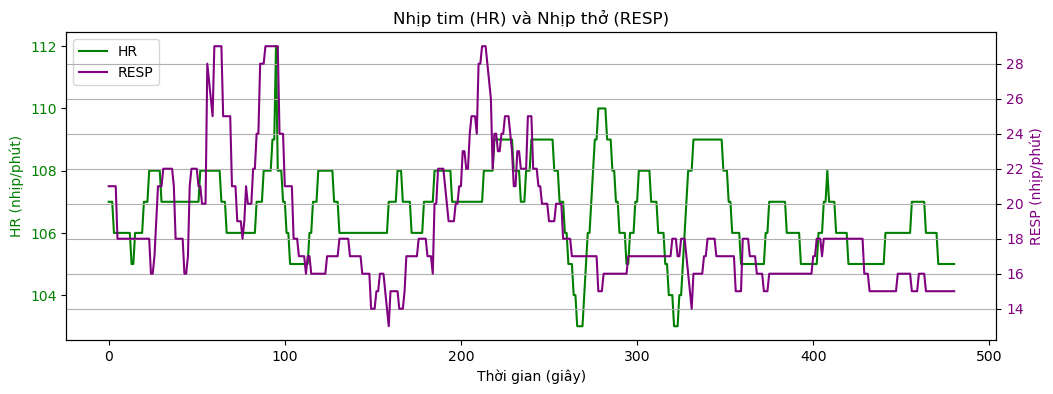

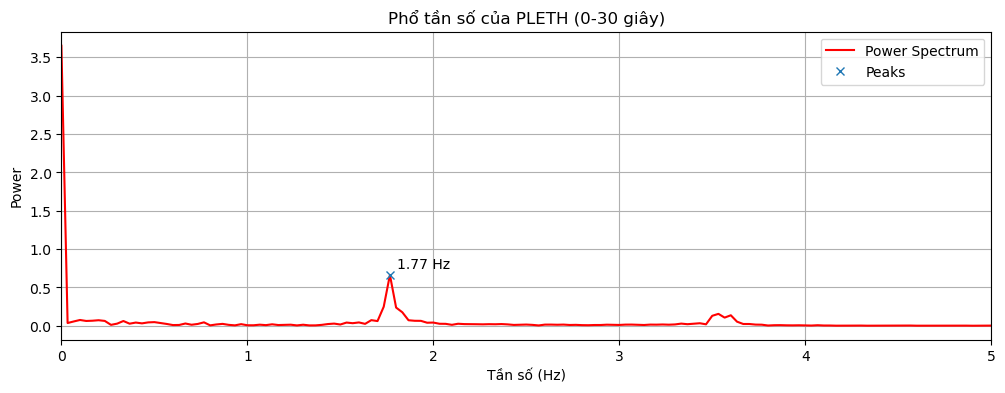

Trực quan hóa dữ liệu cho filtered_data\bidmc_05


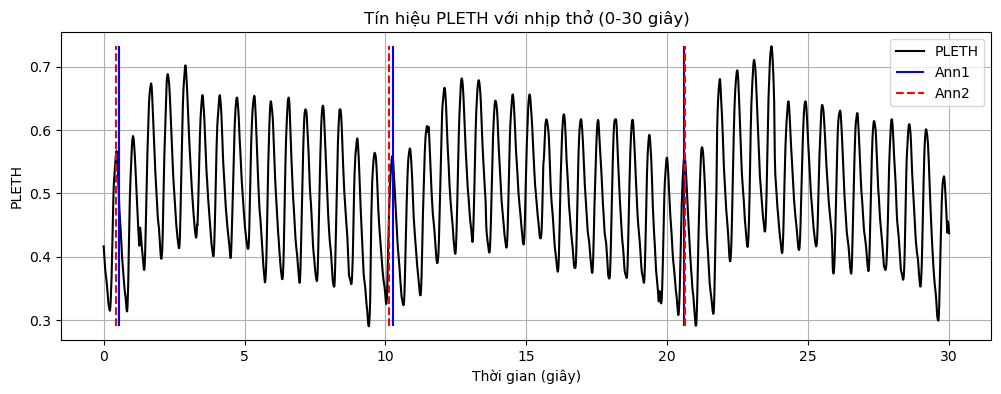

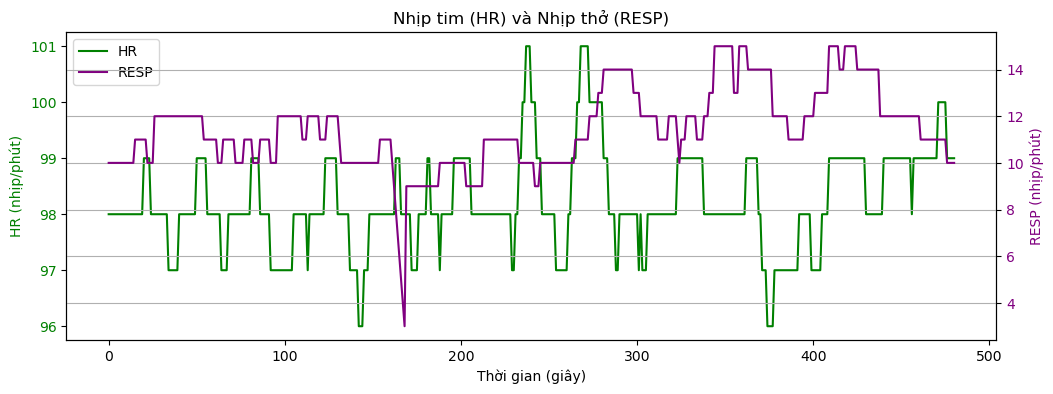

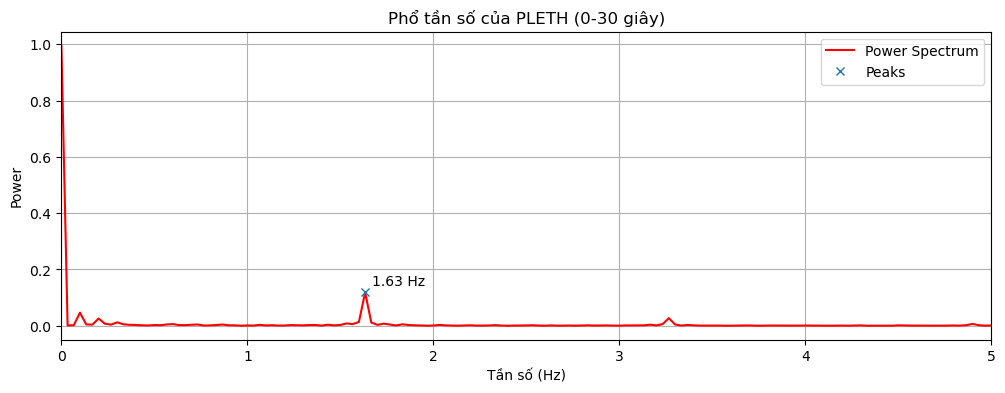

In [5]:
# Chọn ngẫu nhiên 3 subject
selected_subj_folders = random.sample(subj_folders, 3)
for subj_folder in selected_subj_folders:
    
    # Đọc dữ liệu từ các file đã lưu
    signals_file = os.path.join(subj_folder, "Signals_filtered.csv")
    numerics_file = os.path.join(subj_folder, "Numerics_filtered.csv")
    breaths_file = os.path.join(subj_folder, "Breaths_filtered.csv")
    
    df_signals = pd.read_csv(signals_file)
    df_numerics = pd.read_csv(numerics_file)
    df_breaths = pd.read_csv(breaths_file)
    print(f"Trực quan hóa dữ liệu cho {subj_folder}")
    # Vẽ tín hiệu PLETH với breath annotations
    plot_pleth_with_breaths(df_signals, df_breaths, duration=30)
    
    # Vẽ biểu đồ HR và RESP
    plot_hr_resp(df_numerics)
    
    # Vẽ phổ tần số của tín hiệu PLETH
    plot_frequency_spectrum(df_signals, duration=30)

## Bắt đầu lọc nhiễu

Trực quan hóa dữ liệu cho filtered_data\bidmc_05


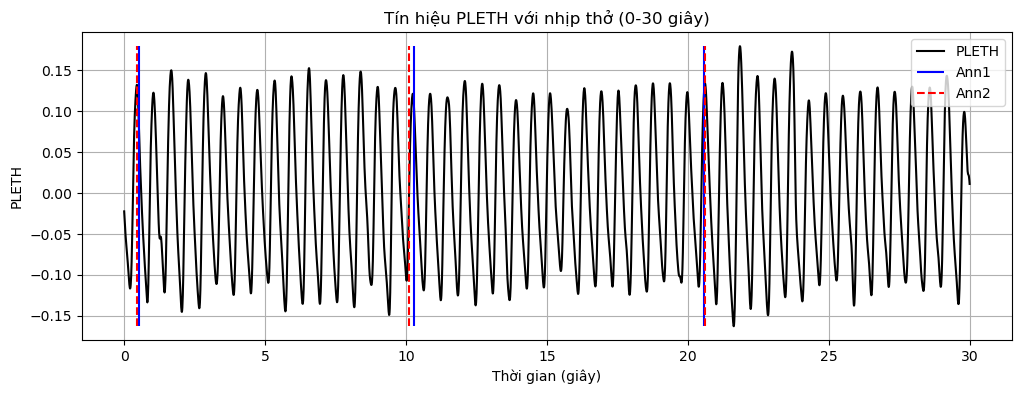

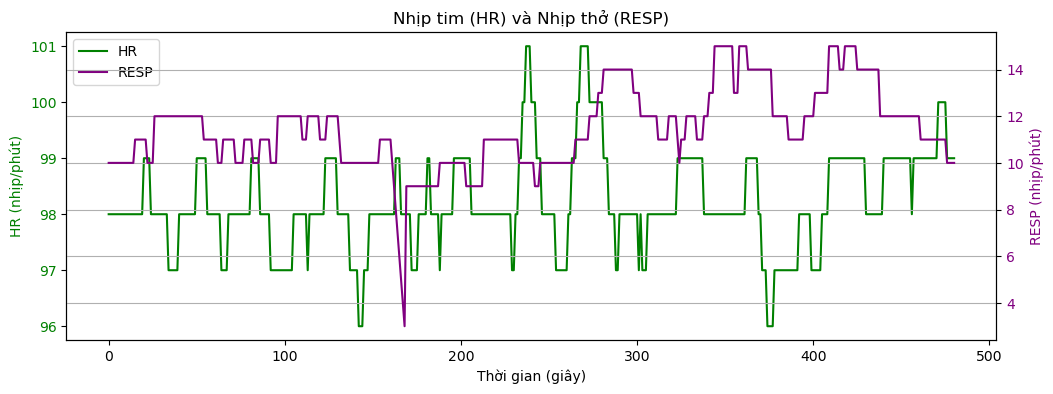

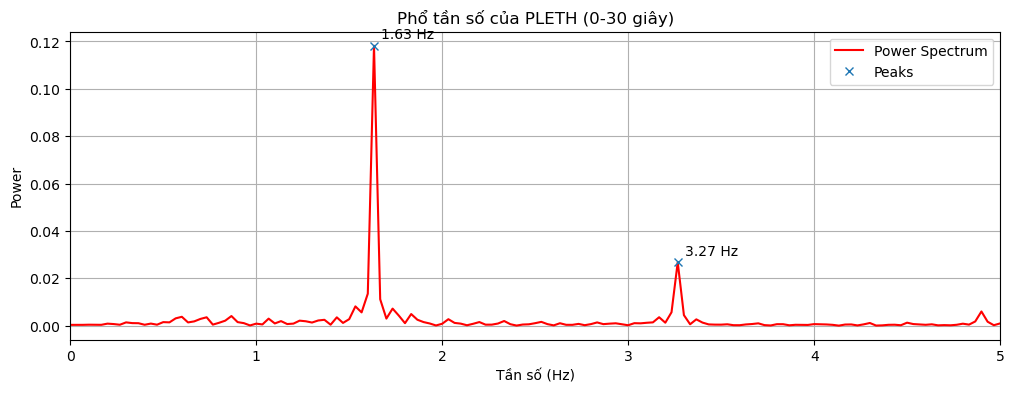

Trực quan hóa dữ liệu cho filtered_data\bidmc_14


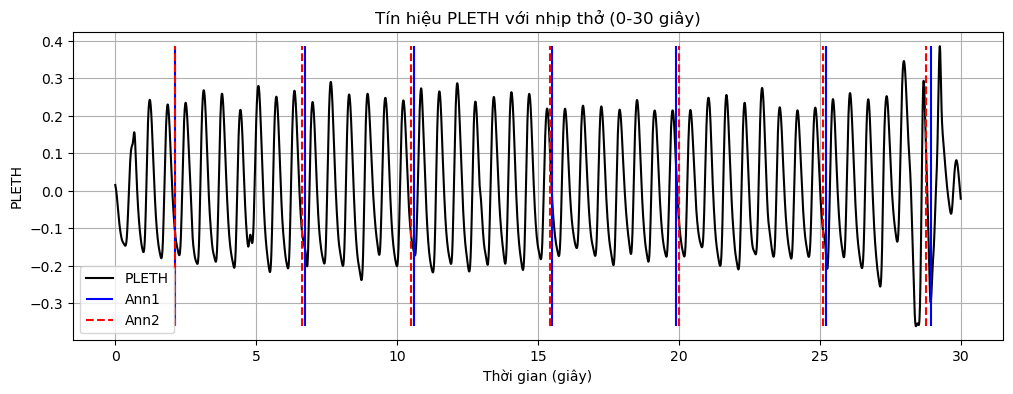

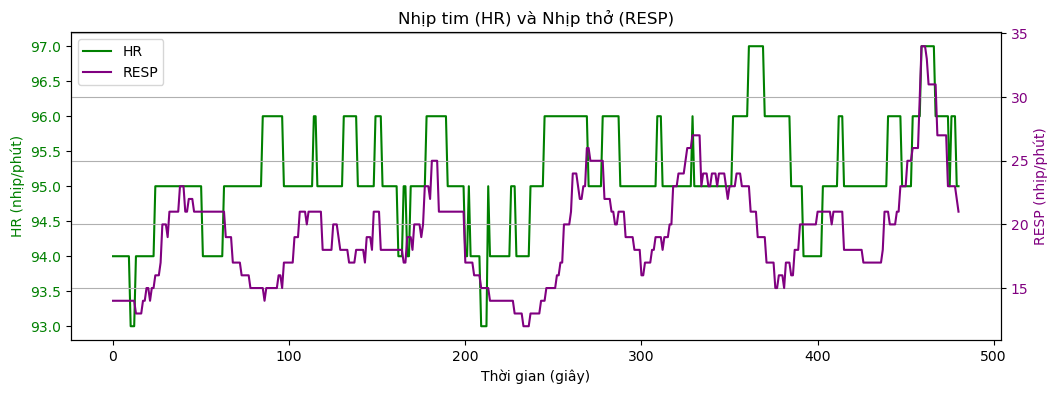

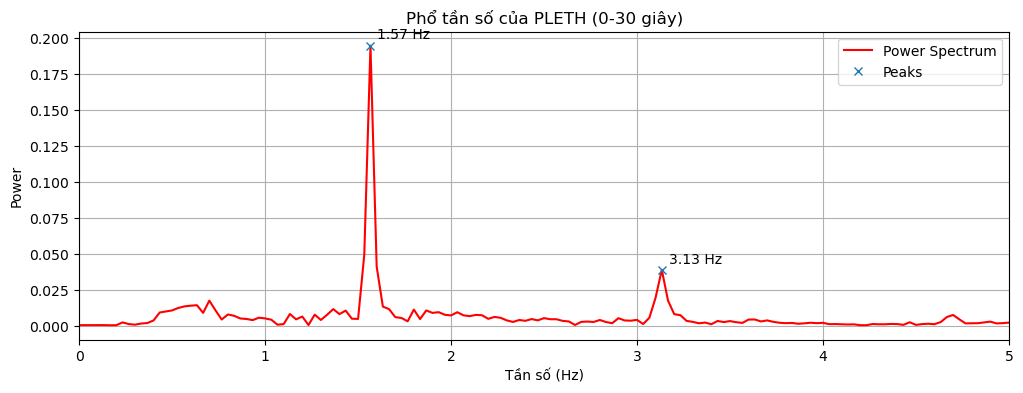

Trực quan hóa dữ liệu cho filtered_data\bidmc_46


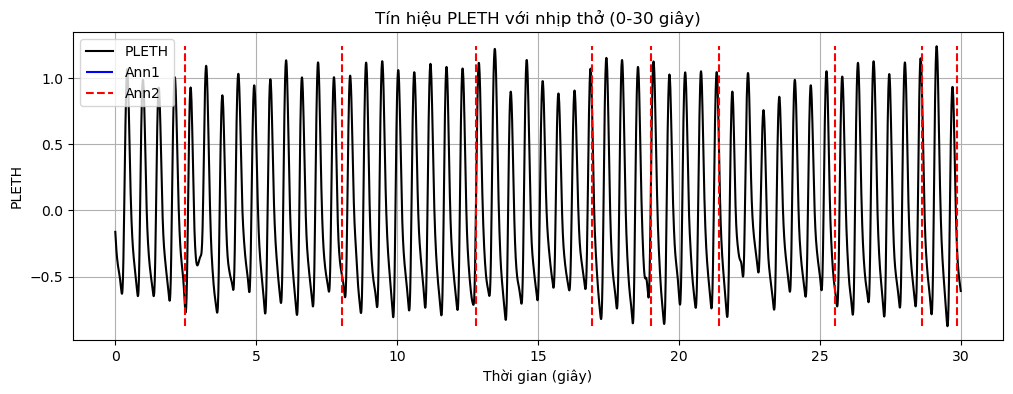

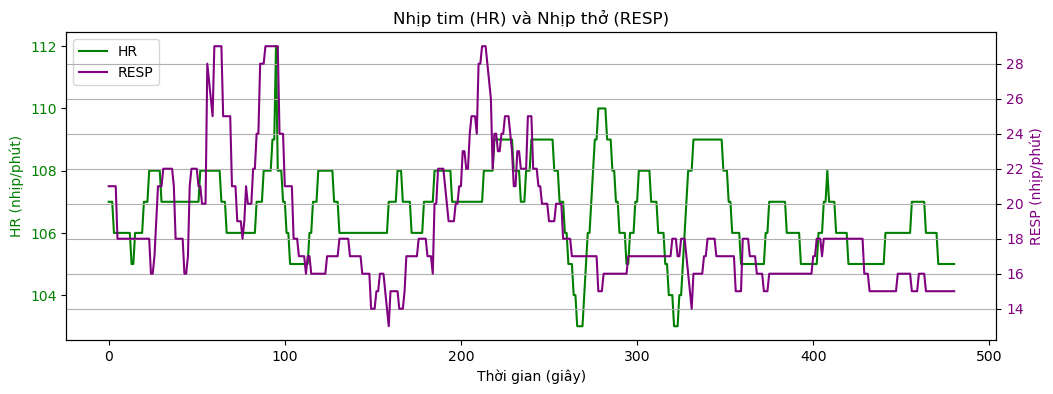

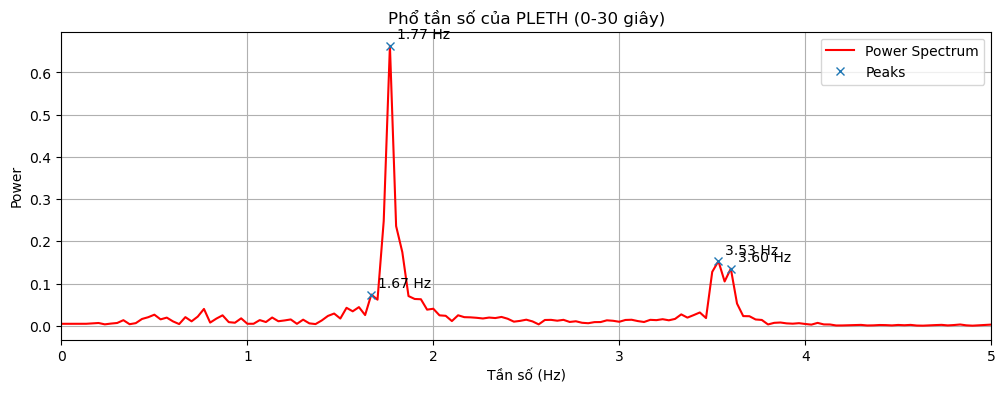

In [6]:


# Hàm bandpass filter cho tín hiệu PPG
def bandpass_filter(signal, lowcut=0.5, highcut=8.0, fs=125.0, order=2):
    nyq = 0.5 * fs  # Tần số Nyquist
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Khởi tạo danh sách để lưu trữ segments và conditions từ tất cả các subjects
all_ppg_segments = []
all_hr_segments = []
all_resp_segments = []

# Số giây cho mỗi đoạn
segment_seconds = 10
segment_length = 125 * segment_seconds  # 1250 mẫu cho mỗi đoạn PPG

# Lặp qua từng subject
for subject in subj_ids:
    subject_dir = os.path.join(output_folder, f"bidmc_{subject}")
    
    # Đường dẫn đến file dữ liệu
    ppg_file = os.path.join(subject_dir, 'Signals_filtered.csv')
    breaths_file = os.path.join(subject_dir, 'Breaths_filtered.csv')
    numeric_file = os.path.join(subject_dir, 'Numerics_filtered.csv')
    
    
    # Kiểm tra file tồn tại
    if not os.path.exists(ppg_file) or not os.path.exists(numeric_file):
        print(f"File not found for subject {subject}, skipping...")
        continue
    
    # Đọc dữ liệu
    ppg_data = pd.read_csv(ppg_file)      # Giả sử có cột: 'Time [s]', 'PLETH'
    breaths_data = pd.read_csv(breaths_file)  # Giả sử có cột: 'ann1', 'ann2'
    numeric_data = pd.read_csv(numeric_file)  # Giả sử có cột: 'Time [s]', 'HR', 'RESP'
    
    # Lọc tín hiệu PPG
    ppg_data['PLETH'] = bandpass_filter(ppg_data['PLETH'].values, lowcut=0.5, highcut=8.0, fs=125.0)


    if os.path.normpath(subject_dir) in selected_subj_folders:
        print(f"Trực quan hóa dữ liệu cho {subject_dir}")
        
        # Vẽ tín hiệu PLETH với breath annotations
        plot_pleth_with_breaths(ppg_data, breaths_data, duration=30)
        
        # Vẽ biểu đồ HR và RESP
        plot_hr_resp(numeric_data)
        
        # Vẽ phổ tần số của tín hiệu PLETH
        plot_frequency_spectrum(ppg_data, duration=30)
    
    # Số đoạn có thể cắt
    num_segments = len(ppg_data) // segment_length
    
    for t in range(num_segments):
        start_idx = t * segment_length
        end_idx = start_idx + segment_length
        if end_idx <= len(ppg_data):
            # Lấy đoạn PPG (1250 mẫu)
            ppg_segment = ppg_data['PLETH'].iloc[start_idx:end_idx].values
            
            # Với numerics, giả sử mẫu 1Hz nên mỗi đoạn có 10 mẫu
            start_time = t * segment_seconds
            end_time = start_time + segment_seconds
            hr_segment = numeric_data['HR'].iloc[start_time:end_time].values
            resp_segment = numeric_data['RESP'].iloc[start_time:end_time].values
            
            all_ppg_segments.append(ppg_segment)
            all_hr_segments.append(hr_segment)
            all_resp_segments.append(resp_segment)



## Chuẩn hóa

PPG segments normalized shape: (2544, 1250)
Conditions segments normalized shape: (2544, 2)


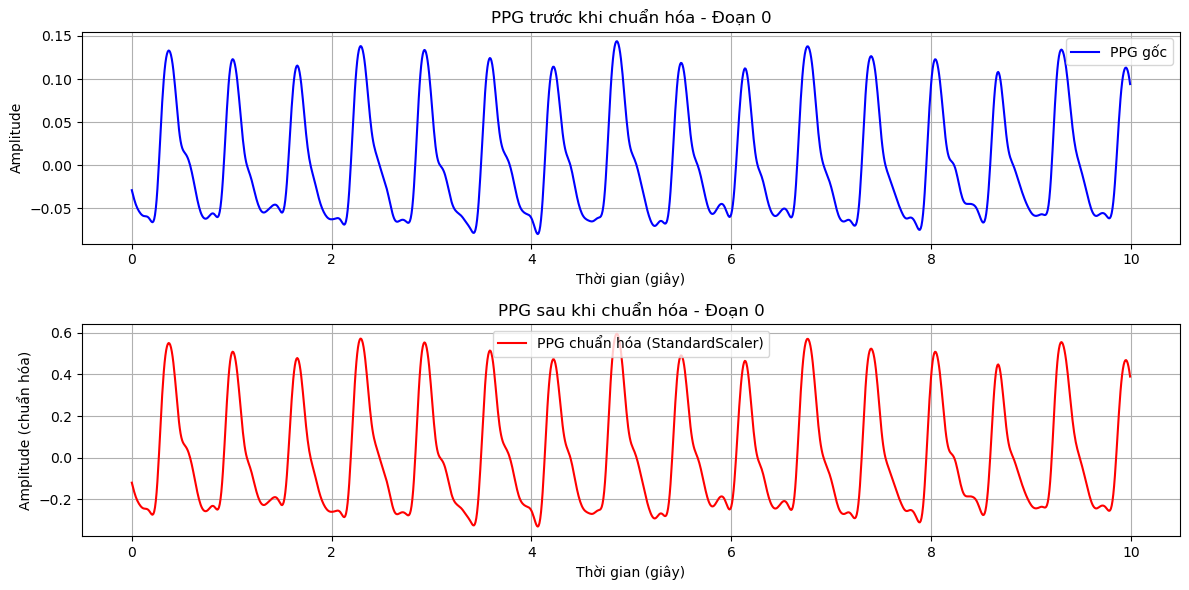

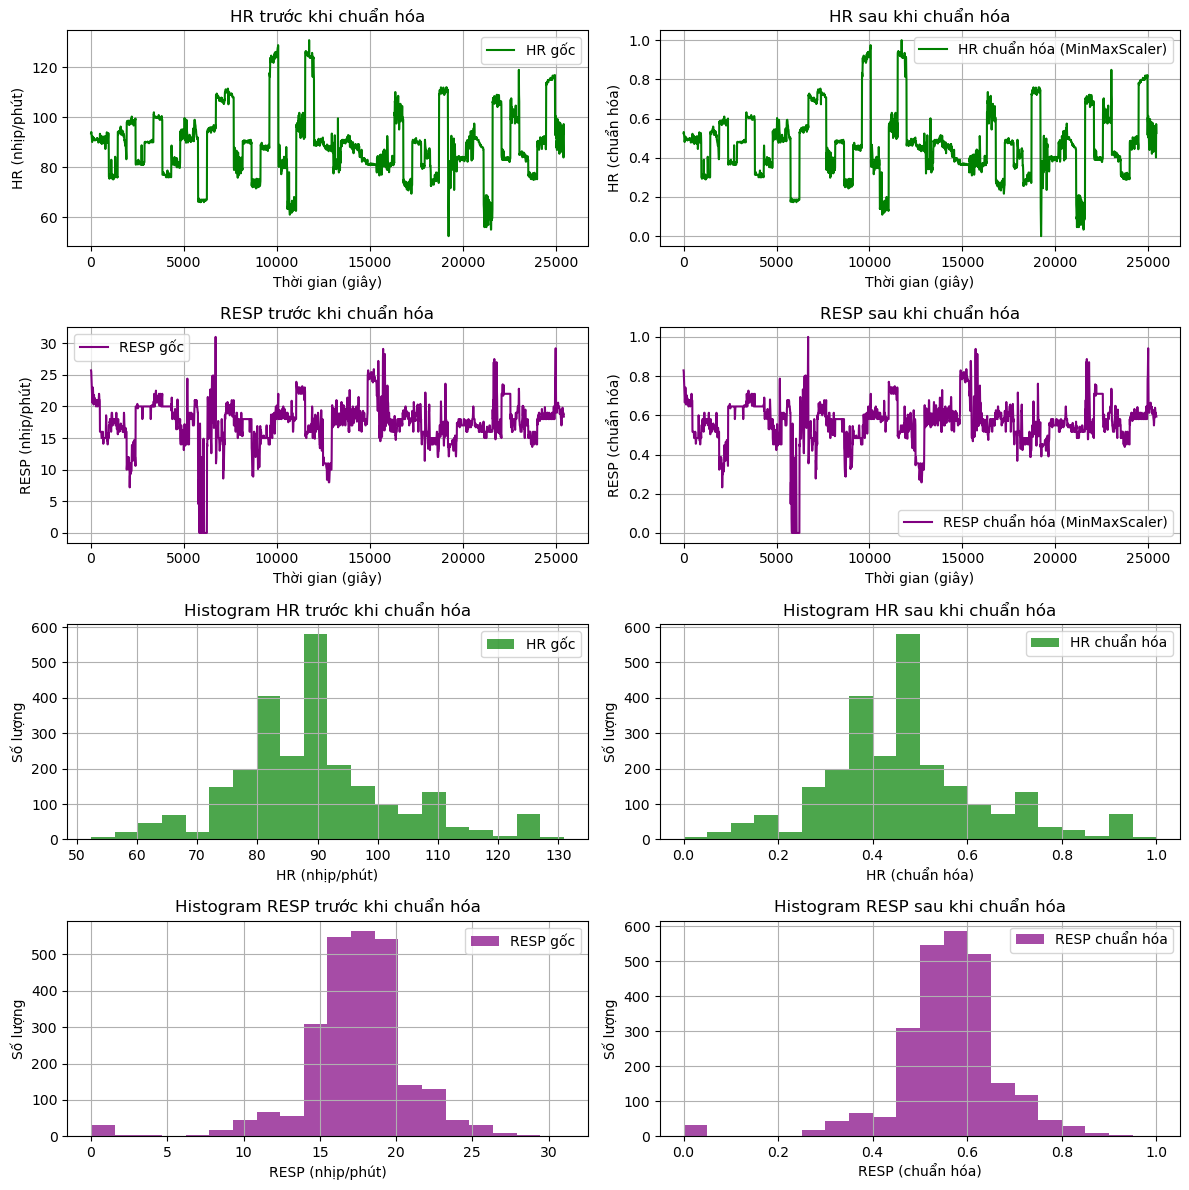

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Giả sử các biến này đã được tính toán trước
# all_ppg_segments: danh sách các đoạn PPG (mỗi đoạn 1250 mẫu)
# all_hr_segments: danh sách các đoạn HR
# all_resp_segments: danh sách các đoạn RESP

# --- Normalization ---
# 1. Normalize toàn cục PPG
ppg_all = np.array(all_ppg_segments)  # Shape: (total_segments, 1250)
ppg_scaler = StandardScaler()
ppg_scaler.fit(ppg_all.reshape(-1, 1))
ppg_segments_normalized = ppg_scaler.transform(ppg_all.reshape(-1, 1)).reshape(ppg_all.shape)
print("PPG segments normalized shape:", ppg_segments_normalized.shape)

# 2. Normalize HR và RESP
hr_means = np.array([np.mean(seg) for seg in all_hr_segments])  # Trung bình mỗi đoạn HR
resp_means = np.array([np.mean(seg) for seg in all_resp_segments])  # Trung bình mỗi đoạn RESP
conditions_raw = np.stack([hr_means, resp_means], axis=1)  # Shape: (total_segments, 2)

minmax_scaler = MinMaxScaler(feature_range=(0, 1))
conditions_segments_normalized = minmax_scaler.fit_transform(conditions_raw)  # Shape: (total_segments, 2)
print("Conditions segments normalized shape:", conditions_segments_normalized.shape)

# --- Visualization ---
def plot_ppg_comparison(original_data, normalized_data, segment_idx=0, fs=125):
    """
    Vẽ so sánh tín hiệu PPG trước và sau khi chuẩn hóa.
    
    Parameters:
    - original_data: numpy array chứa dữ liệu PPG gốc (shape: total_segments, 1250)
    - normalized_data: numpy array chứa dữ liệu PPG đã chuẩn hóa (shape: total_segments, 1250)
    - segment_idx: chỉ số đoạn cần vẽ (mặc định: 0)
    - fs: tần số lấy mẫu (mặc định: 125 Hz)
    """
    time = np.arange(0, len(original_data[segment_idx])) / fs  # Trục thời gian (giây)
    
    plt.figure(figsize=(12, 6))
    
    # Trước chuẩn hóa
    plt.subplot(2, 1, 1)
    plt.plot(time, original_data[segment_idx], 'b-', label='PPG gốc')
    plt.xlabel('Thời gian (giây)')
    plt.ylabel('Amplitude')
    plt.title(f'PPG trước khi chuẩn hóa - Đoạn {segment_idx}')
    plt.legend()
    plt.grid(True)
    
    # Sau chuẩn hóa
    plt.subplot(2, 1, 2)
    plt.plot(time, normalized_data[segment_idx], 'r-', label='PPG chuẩn hóa (StandardScaler)')
    plt.xlabel('Thời gian (giây)')
    plt.ylabel('Amplitude (chuẩn hóa)')
    plt.title(f'PPG sau khi chuẩn hóa - Đoạn {segment_idx}')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_conditions_comparison(original_data, normalized_data, segment_duration=10):
    """
    Vẽ so sánh HR và RESP trước và sau khi chuẩn hóa, bao gồm cả line plot và histogram.
    
    Parameters:
    - original_data: numpy array chứa HR và RESP gốc (shape: total_segments, 2)
    - normalized_data: numpy array chứa HR và RESP đã chuẩn hóa (shape: total_segments, 2)
    - segment_duration: độ dài mỗi đoạn theo giây (mặc định: 10 giây)
    """
    total_segments = original_data.shape[0]
    time = np.arange(total_segments) * segment_duration  # Trục thời gian (giây)
    
    # Tạo figure với 4 hàng: 2 hàng cho line plot, 2 hàng cho histogram
    plt.figure(figsize=(12, 12))
    
    # --- Line plot ---
    # HR trước chuẩn hóa
    plt.subplot(4, 2, 1)
    plt.plot(time, original_data[:, 0], 'g-', label='HR gốc')
    plt.xlabel('Thời gian (giây)')
    plt.ylabel('HR (nhịp/phút)')
    plt.title('HR trước khi chuẩn hóa')
    plt.legend()
    plt.grid(True)
    
    # HR sau chuẩn hóa
    plt.subplot(4, 2, 2)
    plt.plot(time, normalized_data[:, 0], 'g-', label='HR chuẩn hóa (MinMaxScaler)')
    plt.xlabel('Thời gian (giây)')
    plt.ylabel('HR (chuẩn hóa)')
    plt.title('HR sau khi chuẩn hóa')
    plt.legend()
    plt.grid(True)
    
    # RESP trước chuẩn hóa
    plt.subplot(4, 2, 3)
    plt.plot(time, original_data[:, 1], 'purple', label='RESP gốc')
    plt.xlabel('Thời gian (giây)')
    plt.ylabel('RESP (nhịp/phút)')
    plt.title('RESP trước khi chuẩn hóa')
    plt.legend()
    plt.grid(True)
    
    # RESP sau chuẩn hóa
    plt.subplot(4, 2, 4)
    plt.plot(time, normalized_data[:, 1], 'purple', label='RESP chuẩn hóa (MinMaxScaler)')
    plt.xlabel('Thời gian (giây)')
    plt.ylabel('RESP (chuẩn hóa)')
    plt.title('RESP sau khi chuẩn hóa')
    plt.legend()
    plt.grid(True)
    
    # --- Histogram ---
    # Histogram HR trước chuẩn hóa
    plt.subplot(4, 2, 5)
    plt.hist(original_data[:, 0], bins=20, color='green', alpha=0.7, label='HR gốc')
    plt.xlabel('HR (nhịp/phút)')
    plt.ylabel('Số lượng')
    plt.title('Histogram HR trước khi chuẩn hóa')
    plt.legend()
    plt.grid(True)
    
    # Histogram HR sau chuẩn hóa
    plt.subplot(4, 2, 6)
    plt.hist(normalized_data[:, 0], bins=20, color='green', alpha=0.7, label='HR chuẩn hóa')
    plt.xlabel('HR (chuẩn hóa)')
    plt.ylabel('Số lượng')
    plt.title('Histogram HR sau khi chuẩn hóa')
    plt.legend()
    plt.grid(True)
    
    # Histogram RESP trước chuẩn hóa
    plt.subplot(4, 2, 7)
    plt.hist(original_data[:, 1], bins=20, color='purple', alpha=0.7, label='RESP gốc')
    plt.xlabel('RESP (nhịp/phút)')
    plt.ylabel('Số lượng')
    plt.title('Histogram RESP trước khi chuẩn hóa')
    plt.legend()
    plt.grid(True)
    
    # Histogram RESP sau chuẩn hóa
    plt.subplot(4, 2, 8)
    plt.hist(normalized_data[:, 1], bins=20, color='purple', alpha=0.7, label='RESP chuẩn hóa')
    plt.xlabel('RESP (chuẩn hóa)')
    plt.ylabel('Số lượng')
    plt.title('Histogram RESP sau khi chuẩn hóa')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Vẽ biểu đồ so sánh
# So sánh PPG
plot_ppg_comparison(ppg_all, ppg_segments_normalized, segment_idx=0)

# So sánh HR và RESP (bao gồm histogram)
plot_conditions_comparison(conditions_raw, conditions_segments_normalized)

In [8]:
pd.DataFrame(ppg_segments_normalized)

,0,1,2,3,4,5,6,7,8,9,...,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249
0,-0.120444,-0.135864,-0.150825,-0.164890,-0.177726,-0.189145,-0.199125,-0.207790,-0.215345,-0.221989,...,0.425318,0.446205,0.460139,0.467541,0.468784,0.464131,0.453738,0.437717,0.416218,0.389538
1,0.358219,0.323123,0.285459,0.246725,0.208564,0.172548,0.139952,0.111584,0.087693,0.067989,...,-0.301332,-0.306370,-0.312414,-0.319024,-0.325376,-0.330295,-0.332302,-0.329692,-0.320643,-0.303357
2,-0.276245,-0.238158,-0.188613,-0.127959,-0.057422,0.020996,0.104752,0.190987,0.276660,0.358641,...,0.001048,-0.010481,-0.023541,-0.038393,-0.055091,-0.073493,-0.093265,-0.113914,-0.134828,-0.155327
3,-0.174723,-0.192400,-0.207892,-0.220935,-0.231470,-0.239610,-0.245568,-0.249598,-0.251957,-0.252900,...,-0.241032,-0.241711,-0.242859,-0.244798,-0.247926,-0.252621,-0.259120,-0.267395,-0.277057,-0.287274
4,-0.296754,-0.303773,-0.306258,-0.301931,-0.288539,-0.264173,-0.227593,-0.178498,-0.117691,-0.047098,...,0.066312,0.141950,0.216196,0.285927,0.348588,0.402378,0.446298,0.480066,0.503961,0.518600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539,-1.963690,-2.051896,-2.135711,-2.215558,-2.291701,-2.364262,-2.433258,-2.498637,-2.560323,-2.618273,...,-2.597079,-2.685273,-2.771747,-2.855126,-2.932989,-3.001697,-3.056296,-3.090484,-3.096608,-3.065887
2540,-2.989041,-2.857354,-2.663946,-2.405015,-2.080759,-1.695757,-1.258671,-0.781246,-0.276828,0.241024,...,3.162755,3.589995,3.949895,4.242797,4.471172,4.638575,4.748651,4.804593,4.809075,4.764503
2541,4.673390,4.538758,4.364462,4.155383,3.917402,3.657126,3.381400,3.096836,2.809567,2.525187,...,0.234858,0.070229,-0.086128,-0.237215,-0.385597,-0.533163,-0.681022,-0.829498,-0.978208,-1.126220
2542,-1.272268,-1.414995,-1.553228,-1.686209,-1.813674,-1.935651,-2.052146,-2.162946,-2.267639,-2.365739,...,-0.903156,-0.856745,-0.783010,-0.682357,-0.556960,-0.410789,-0.249425,-0.079681,0.090957,0.254958


In [9]:
pd.DataFrame(conditions_segments_normalized)

,0,1
0,0.524841,0.829032
1,0.531210,0.822581
2,0.529936,0.793548
3,0.518471,0.774194
4,0.512102,0.735484
...,...,...
2539,0.556688,0.603226
2540,0.489172,0.612903
2541,0.401274,0.600000
2542,0.571975,0.600000


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, C_train, C_test = train_test_split(ppg_segments_normalized, conditions_segments_normalized, test_size=0.2)

print(X_train.shape, C_train.shape)  # Kiểm tra kích thước dữ liệu huấn luyện
print(X_test.shape, C_test.shape)  # Kiểm tra kích thước dữ liệu kiểm tra

(2035, 1250) (2035, 2)
(509, 1250) (509, 2)


## Thiết kế mô hình

In [11]:
class Encoder(nn.Module):
    def __init__(self, input_dim=1250, condition_dim=2, latent_dim=32):
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        
        # Giản lược CNN chỉ còn 2 lớp
        self.conv1 = nn.Conv1d(1, 16, 7, stride=4, padding=3)  # (1250 -> 313)
        self.conv2 = nn.Conv1d(16, 32, 5, stride=2, padding=2)  # (313 -> 157)
        
        # Tính toán kích thước sau CNN
        self.flatten_size = 32 * 157
        
        # Thêm nhiều lớp Dense hơn
        self.fc_layers = nn.Sequential(
            nn.Linear(self.flatten_size + condition_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )
        
        # Latent space
        self.fc_mean = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

    def forward(self, x, condition):
        # Xử lý CNN
        x = x.view(-1, 1, self.input_dim)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        # Kết hợp condition và qua FC
        x = x.view(x.size(0), -1)
        x = torch.cat([x, condition], dim=1)
        x = self.fc_layers(x)
        
        return self.fc_mean(x), self.fc_logvar(x)

In [12]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=32, condition_dim=2, output_dim=1250):
        super(Decoder, self).__init__()
        # Mở rộng với nhiều lớp Dense
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 32 * 157)  # Khớp với Encoder output
        )
        
        # Điều chỉnh tham số deconv
        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose1d(32, 16, 5, stride=2, padding=2),  # 157 -> 313
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, 7, stride=4, padding=3, output_padding=1)  # 313 -> 1250
        )

    def forward(self, z, condition):
        # Xử lý FC
        x = torch.cat([z, condition], dim=1)
        x = self.fc_layers(x).view(-1, 32, 157)  # Khớp shape với Encoder
        
        # Xử lý deconv
        x = self.deconv_layers(x)
        return x.view(-1, 1250)  # Đảm bảo output_dim chính xác

In [13]:
class CVAE(nn.Module):
    def __init__(self, input_dim=1250, condition_dim=2, latent_dim=32):
        super(CVAE, self).__init__()
        self.encoder = Encoder(input_dim, condition_dim, latent_dim)
        self.decoder = Decoder(latent_dim, condition_dim, input_dim)
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x, condition):
        mean, logvar = self.encoder(x, condition)
        z = self.reparameterize(mean, logvar)
        x_recon = self.decoder(z, condition)
        return x_recon, mean, logvar

In [14]:
# Test Decoder
decoder = Decoder()
z = torch.randn(64, 32)
condition = torch.randn(64, 2)
output = decoder(z, condition)
print(output.shape)  # Phải ra torch.Size([64, 1250])

# Test full model
model = CVAE()
x = torch.randn(64, 1250)
cond = torch.randn(64, 2)
recon, _, _ = model(x, cond)
print(recon.shape)  # Phải ra torch.Size([64, 1250])

torch.Size([64, 1250])
torch.Size([64, 1250])


In [15]:
def loss_function(x_recon, x, mean, logvar, beta=1.0):
    mse = F.mse_loss(x_recon, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return mse + beta * kl, mse, kl, beta

## Train mô hình

Epoch 10, Train Loss: 445.9539, MSE: 445.9539, KL: 336.3247, Beta: 0.0000
Epoch 10, Test Loss: 528.7508, MSE: 528.7508, KL: 338.7384


Epoch 20, Train Loss: 204.9310, MSE: 204.9310, KL: 624.8764, Beta: 0.0000
Epoch 20, Test Loss: 442.3547, MSE: 442.3547, KL: 616.9855


Epoch 30, Train Loss: 159.6318, MSE: 133.8016, KL: 103.3208, Beta: 0.2500
Epoch 30, Test Loss: 415.3945, MSE: 391.9905, KL: 93.6163


Epoch 40, Train Loss: 142.1737, MSE: 109.8193, KL: 64.7088, Beta: 0.5000
Epoch 40, Test Loss: 436.5406, MSE: 402.5231, KL: 68.0350


Epoch 50, Train Loss: 129.2656, MSE: 89.8715, KL: 52.5255, Beta: 0.7500
Epoch 50, Test Loss: 418.0671, MSE: 379.2884, KL: 51.7049


Epoch 60, Train Loss: 139.1932, MSE: 93.7375, KL: 45.4557, Beta: 1.0000
Epoch 60, Test Loss: 422.1330, MSE: 376.9218, KL: 45.2112


Epoch 70, Train Loss: 139.2617, MSE: 95.7108, KL: 43.5509, Beta: 1.0000
Epoch 70, Test Loss: 421.5328, MSE: 378.9853, KL: 42.5474


Epoch 80, Train Loss: 116.1456, MSE: 73.9563, KL: 42.1893, Beta: 1.0000
Epoch 80, Test Loss: 407.2236, MSE: 367.6212, KL: 39.6024


Epoch 90, Train Loss: 114.1019, MSE: 73.3359, KL: 40.7660, Beta: 1.0000
Epoch 90, Test Loss: 408.1954, MSE: 368.9144, KL: 39.2810


Epoch 100, Train Loss: 103.1698, MSE: 63.7762, KL: 39.3936, Beta: 1.0000
Epoch 100, Test Loss: 397.8305, MSE: 360.8784, KL: 36.9520


Epoch 110, Train Loss: 105.7205, MSE: 67.3825, KL: 38.3380, Beta: 1.0000
Epoch 110, Test Loss: 403.1883, MSE: 365.3543, KL: 37.8340


Epoch 120, Train Loss: 95.4924, MSE: 58.0184, KL: 37.4741, Beta: 1.0000
Epoch 120, Test Loss: 389.3984, MSE: 352.5266, KL: 36.8718


Epoch 130, Train Loss: 96.1733, MSE: 59.5473, KL: 36.6260, Beta: 1.0000
Epoch 130, Test Loss: 396.2983, MSE: 362.0186, KL: 34.2797


Epoch 140, Train Loss: 91.1250, MSE: 55.5507, KL: 35.5743, Beta: 1.0000
Epoch 140, Test Loss: 396.1827, MSE: 360.4639, KL: 35.7188


Epoch 150, Train Loss: 88.6748, MSE: 54.1028, KL: 34.5720, Beta: 1.0000
Epoch 150, Test Loss: 398.3416, MSE: 363.2161, KL: 35.1255


Epoch 160, Train Loss: 84.4248, MSE: 50.8464, KL: 33.5784, Beta: 1.0000
Epoch 160, Test Loss: 394.3340, MSE: 361.2405, KL: 33.0936


Epoch 170, Train Loss: 77.3924, MSE: 44.9473, KL: 32.4451, Beta: 1.0000
Epoch 170, Test Loss: 389.8636, MSE: 358.4923, KL: 31.3713


Epoch 180, Train Loss: 82.7675, MSE: 50.9068, KL: 31.8607, Beta: 1.0000
Epoch 180, Test Loss: 388.1592, MSE: 357.7294, KL: 30.4299


Epoch 190, Train Loss: 71.6984, MSE: 41.3003, KL: 30.3981, Beta: 1.0000
Epoch 190, Test Loss: 380.7564, MSE: 351.2584, KL: 29.4980


Epoch 200, Train Loss: 81.2821, MSE: 50.7283, KL: 30.5538, Beta: 1.0000
Epoch 200, Test Loss: 397.2165, MSE: 369.1239, KL: 28.0927


Epoch 210, Train Loss: 65.2414, MSE: 35.8347, KL: 29.4067, Beta: 1.0000
Epoch 210, Test Loss: 389.1570, MSE: 361.9308, KL: 27.2263


Epoch 220, Train Loss: 70.6002, MSE: 41.6699, KL: 28.9303, Beta: 1.0000
Epoch 220, Test Loss: 388.5331, MSE: 360.4180, KL: 28.1151


Epoch 230, Train Loss: 65.0862, MSE: 36.5352, KL: 28.5509, Beta: 1.0000
Epoch 230, Test Loss: 388.0450, MSE: 360.5785, KL: 27.4665


C:\Users\nguye\AppData\Local\Temp\ipykernel_4948\3099907584.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cvae_loaded.load_state_dict(torch.load(best_model_path))


Early stopping triggered!


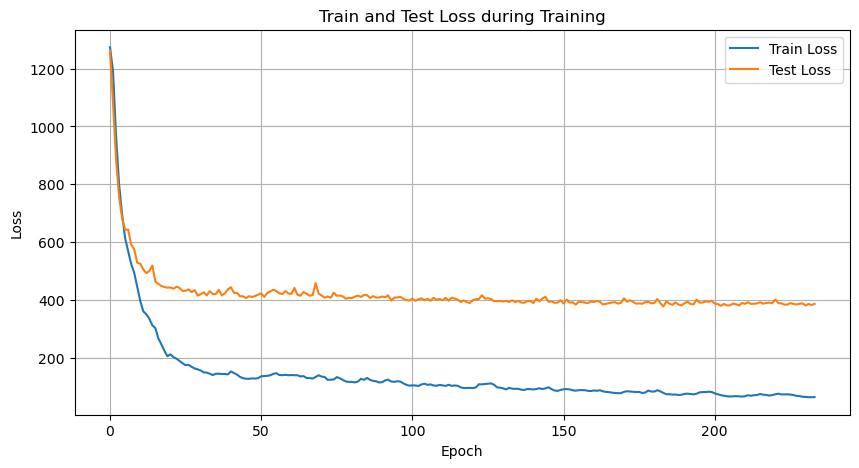

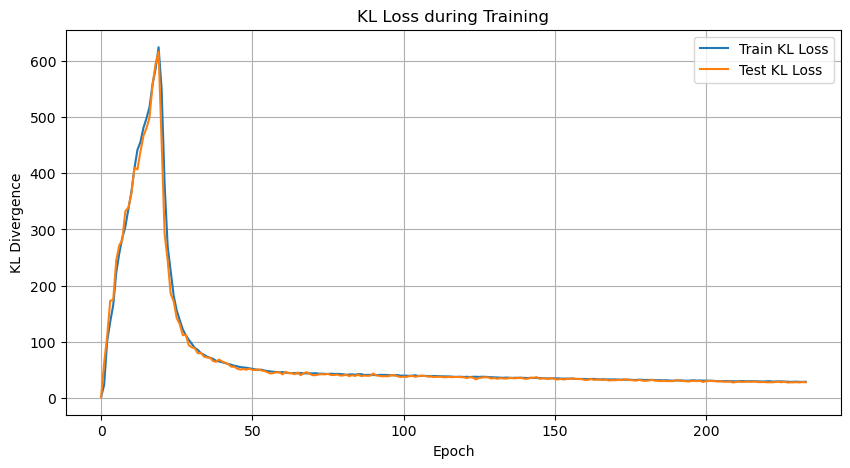

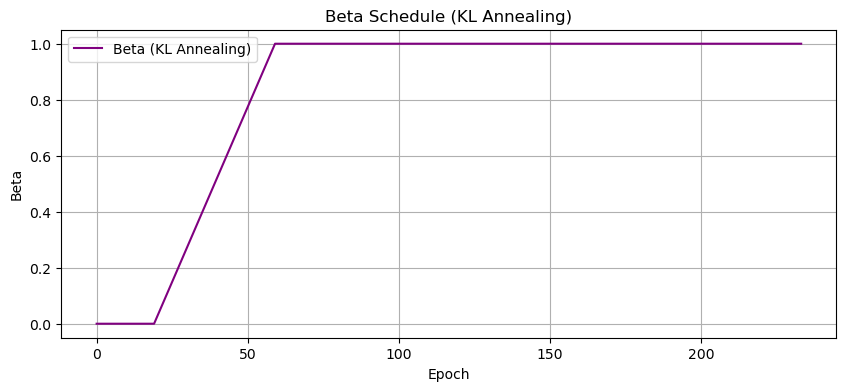

In [16]:


# Chuyển dữ liệu thành tensor
X_train_tensor = torch.FloatTensor(X_train)
C_train_tensor = torch.FloatTensor(C_train)
X_test_tensor = torch.FloatTensor(X_test)
C_test_tensor = torch.FloatTensor(C_test)

# Tạo DataLoader
train_dataset = TensorDataset(X_train_tensor, C_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, C_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Khởi tạo mô hình và optimizer
latent_dim = 32
cvae = CVAE(input_dim=segment_length, condition_dim=2, latent_dim=latent_dim)
optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-3)

# Lưu trữ loss
train_losses = []
test_losses = []
best_test_loss = float('inf')
best_model_path = 'best_cvae_model.pth'

train_kl_losses = []
test_kl_losses = []
beta_history = []

num_epochs = 500
warmup_epochs = 20      # Epoch warm-up (beta = 0)
anneal_duration = 40    # Số epoch tăng beta từ 0 đến 1 sau warm-up
patience = 50
no_improve = 0

# Bắt đầu training
for epoch in range(num_epochs):
    # Tính beta với KL annealing
    if epoch < warmup_epochs:
        beta_val = 0.0
    else:
        beta_val = min(1.0, (epoch - warmup_epochs + 1) / anneal_duration)
    beta_history.append(beta_val)
    
    cvae.train()
    total_train_loss = 0.0
    total_train_kl_loss = 0.0
    total_train_mse_loss = 0.0
    
    # Dùng tqdm để hiển thị progress bar
    for x, condition in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Train", leave=False):
        optimizer.zero_grad()
        x_recon, mean, logvar = cvae(x, condition)
        # loss_function trả về (loss, mse, kl, beta_out)
        loss, mse, kl, _ = loss_function(x_recon, x, mean, logvar, beta=beta_val)
        loss.backward()
        # (Tùy chọn) Gradient clipping: torch.nn.utils.clip_grad_norm_(cvae.parameters(), max_norm=5.0)
        optimizer.step()
        
        total_train_loss += loss.item()
        total_train_kl_loss += kl.item()
        total_train_mse_loss += mse.item()
    
    avg_train_loss = total_train_loss / len(train_loader.dataset)
    avg_train_kl_loss = total_train_kl_loss / len(train_loader.dataset)
    avg_train_mse_loss = total_train_mse_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    train_kl_losses.append(avg_train_kl_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, MSE: {avg_train_mse_loss:.4f}, KL: {avg_train_kl_loss:.4f}, Beta: {beta_val:.4f}")
    
    # Đánh giá trên tập test
    cvae.eval()
    total_test_loss = 0.0
    total_test_kl_loss = 0.0
    total_test_mse_loss = 0.0
    with torch.no_grad():
        for x, condition in test_loader:
            x_recon, mean, logvar = cvae(x, condition)
            loss, mse, kl, _ = loss_function(x_recon, x, mean, logvar, beta=beta_val)
            total_test_loss += loss.item()
            total_test_kl_loss += kl.item()
            total_test_mse_loss += mse.item()
    
    avg_test_loss = total_test_loss / len(test_loader.dataset)
    avg_test_kl_loss = total_test_kl_loss / len(test_loader.dataset)
    avg_test_mse_loss = total_test_mse_loss / len(test_loader.dataset)
    test_losses.append(avg_test_loss)
    test_kl_losses.append(avg_test_kl_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Test Loss: {avg_test_loss:.4f}, MSE: {avg_test_mse_loss:.4f}, KL: {avg_test_kl_loss:.4f}")
    
    # Lưu mô hình tốt nhất theo test loss
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        torch.save(cvae.state_dict(), best_model_path)
        no_improve = 0
    else:
        no_improve += 1
    
    if no_improve >= patience:
        print("Early stopping triggered!")
        break

# Tải mô hình tốt nhất
cvae_loaded = CVAE(input_dim=segment_length, condition_dim=2, latent_dim=latent_dim)
cvae_loaded.load_state_dict(torch.load(best_model_path))
cvae_loaded.eval()

# Vẽ đồ thị loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss during Training')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_kl_losses, label='Train KL Loss')
plt.plot(test_kl_losses, label='Test KL Loss')
plt.xlabel('Epoch')
plt.ylabel('KL Divergence')
plt.title('KL Loss during Training')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(beta_history, label='Beta (KL Annealing)', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Beta')
plt.title('Beta Schedule (KL Annealing)')
plt.grid(True)
plt.legend()
plt.show()


z_all.shape: (509, 32)
hr_all.shape: (509,)
resp_all.shape: (509,)


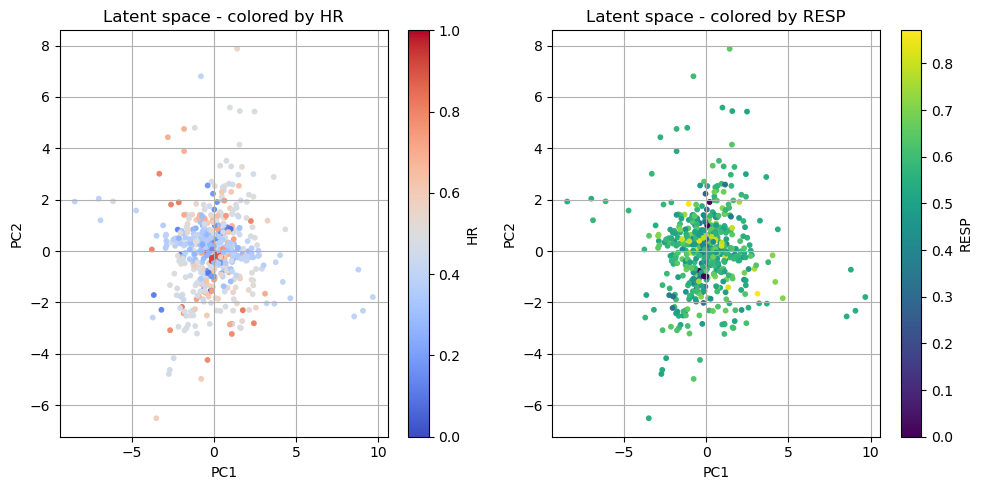

In [17]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Đặt mô hình ở chế độ eval
cvae_loaded.eval()

# Tạo danh sách để lưu latent vectors và nhãn (HR, RESP)
z_list = []
hr_list = []
resp_list = []

# Duyệt qua tập test và thu thập mean (z) từ encoder
with torch.no_grad():
    for x, condition in test_loader:
        _, mean, _ = cvae_loaded(x, condition)
        z_list.append(mean)
        # print(mean.shape)
        hr_list.append(condition[:, 0])     # HR
        resp_list.append(condition[:, 1])   # RESP

# Ghép lại thành tensor
z_all = torch.cat(z_list, dim=0).cpu().numpy()
print("z_all.shape:", z_all.shape)
hr_all = torch.cat(hr_list, dim=0).cpu().numpy()
print("hr_all.shape:", hr_all.shape)
resp_all = torch.cat(resp_list, dim=0).cpu().numpy()
print("resp_all.shape:", resp_all.shape)

# Dùng PCA để giảm từ latent_dim về 2D
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_all)

# Vẽ scatter plot, tô màu theo HR hoặc RESP
plt.figure(figsize=(10, 5))

# Màu theo HR
plt.subplot(1, 2, 1)
plt.scatter(z_pca[:, 0], z_pca[:, 1], c=hr_all, cmap='coolwarm', s=10)
plt.colorbar(label='HR')
plt.title('Latent space - colored by HR')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)

# Màu theo RESP
plt.subplot(1, 2, 2)
plt.scatter(z_pca[:, 0], z_pca[:, 1], c=resp_all, cmap='viridis', s=10)
plt.colorbar(label='RESP')
plt.title('Latent space - colored by RESP')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)

plt.tight_layout()
plt.show()


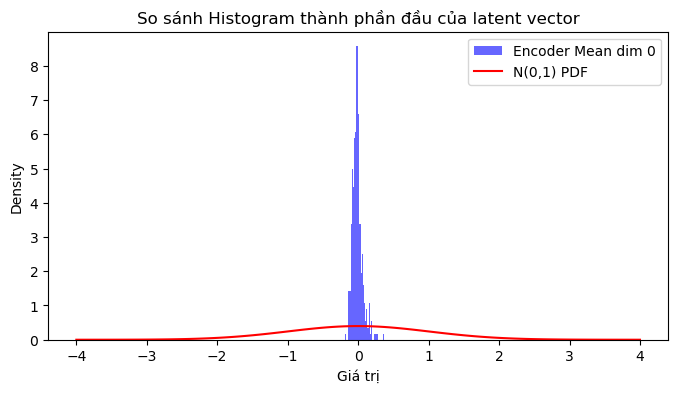

In [18]:


# Giả sử cvae_loaded là mô hình đã huấn luyện và test_loader có dữ liệu x và condition
means = []
with torch.no_grad():
    for x, condition in test_loader:
        # Lấy đầu ra từ encoder: sử dụng output "mean" của q(z|x)
        _, mean, _ = cvae_loaded(x, condition)
        means.append(mean)
        
means = torch.cat(means, dim=0).cpu().numpy()

# Vẽ histogram cho thành phần thứ 1 của vector mean
plt.figure(figsize=(8,4))
plt.hist(means[:, 0], bins=50, density=True, alpha=0.6, color='b', label='Encoder Mean dim 0')

# Vẽ thêm histogram của N(0,1)
x_vals = np.linspace(-4, 4, 100)
pdf = 1/np.sqrt(2*np.pi) * np.exp(-0.5 * x_vals**2)
plt.plot(x_vals, pdf, 'r-', label='N(0,1) PDF')
plt.title('So sánh Histogram thành phần đầu của latent vector')
plt.xlabel('Giá trị')
plt.ylabel('Density')
plt.legend()
plt.show()

Average MSE on Test Set: 0.2781


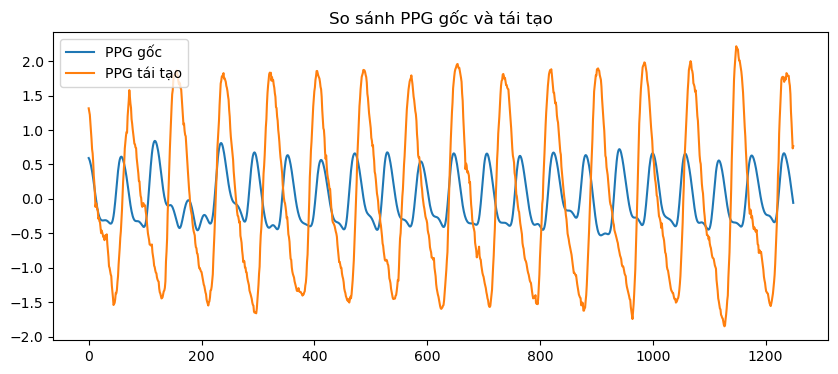

In [19]:
# Đánh giá trên tập test (MSE trung bình)
cvae_loaded.eval()
total_mse = 0
with torch.no_grad():
    for x, condition in test_loader:
        x_recon, _, _ = cvae_loaded(x, condition)
        mse = F.mse_loss(x_recon, x, reduction='mean')
        total_mse += mse.item()
avg_mse = total_mse / len(test_loader)
print(f"Average MSE on Test Set: {avg_mse:.4f}")

# So sánh PPG gốc và tái tạo
plt.figure(figsize=(10, 4))
plt.plot(X_test[3], label='PPG gốc')
plt.plot(x_recon[3].numpy(), label='PPG tái tạo')
plt.legend()
plt.title("So sánh PPG gốc và tái tạo")
plt.show()


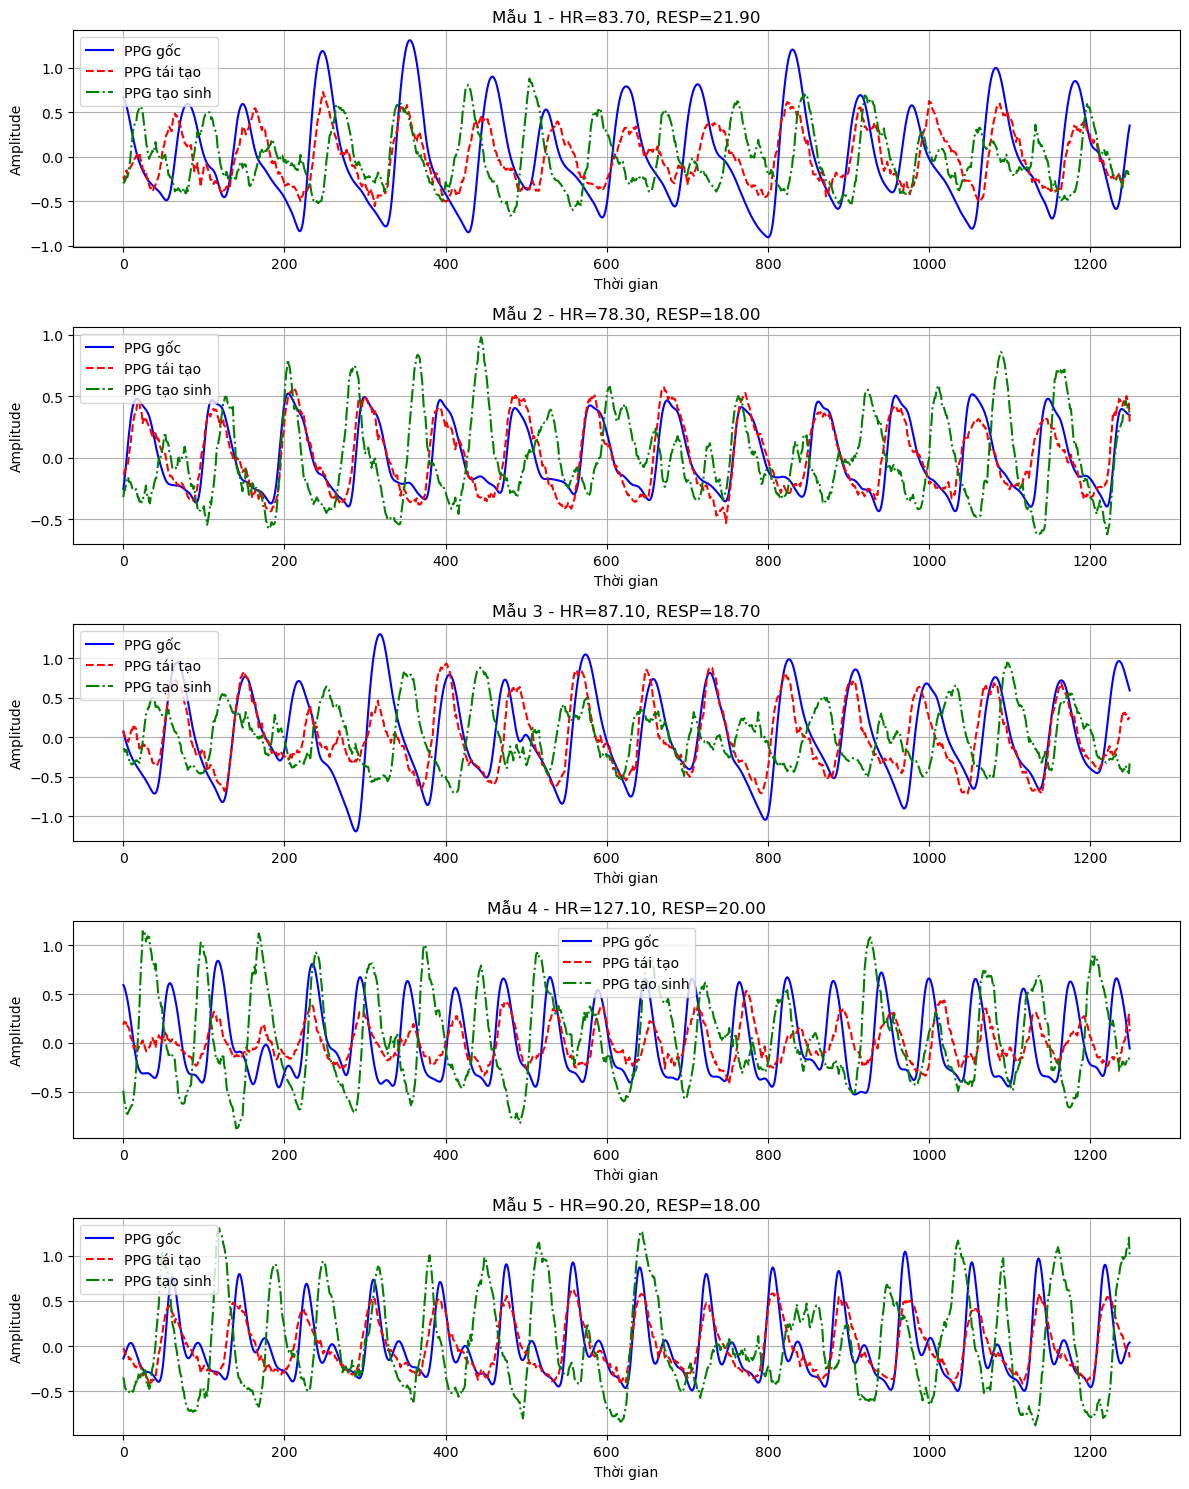

In [20]:

# Số mẫu muốn hiển thị
num_samples = 5

# Lấy nhiều mẫu từ tập test
x_norms = X_test_tensor[:num_samples]
c_norms = C_test_tensor[:num_samples]

# Inverse transform để lấy lại HR và RESP gốc
conditions_denorm = minmax_scaler.inverse_transform(c_norms.numpy())

# Khởi tạo danh sách kết quả
x_recons = []
x_gens = []

# Tái tạo và tạo sinh với mỗi điều kiện
cvae_loaded.eval()
with torch.no_grad():
    for i in range(num_samples):
        x = x_norms[i].unsqueeze(0)  # Thêm chiều batch
        c = c_norms[i].unsqueeze(0)

        # Tái tạo
        x_recon, _, _ = cvae_loaded(x, c)
        x_recons.append(x_recon[0])

        # Tạo latent vector ngẫu nhiên và tạo sinh
        z = torch.randn(1, latent_dim)
        x_gen = cvae_loaded.decoder(z, c)
        x_gens.append(x_gen[0])

# Vẽ
plt.figure(figsize=(12, num_samples * 3))
for i in range(num_samples):
    hr, resp = conditions_denorm[i]
    plt.subplot(num_samples, 1, i + 1)
    plt.plot(x_norms[i].numpy(), label='PPG gốc', color='blue')
    plt.plot(x_recons[i].numpy(), label='PPG tái tạo', color='red', linestyle='--')
    plt.plot(x_gens[i].numpy(), label='PPG tạo sinh', color='green', linestyle='-.')
    plt.title(f'Mẫu {i+1} - HR={hr:.2f}, RESP={resp:.2f}')
    plt.xlabel('Thời gian')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


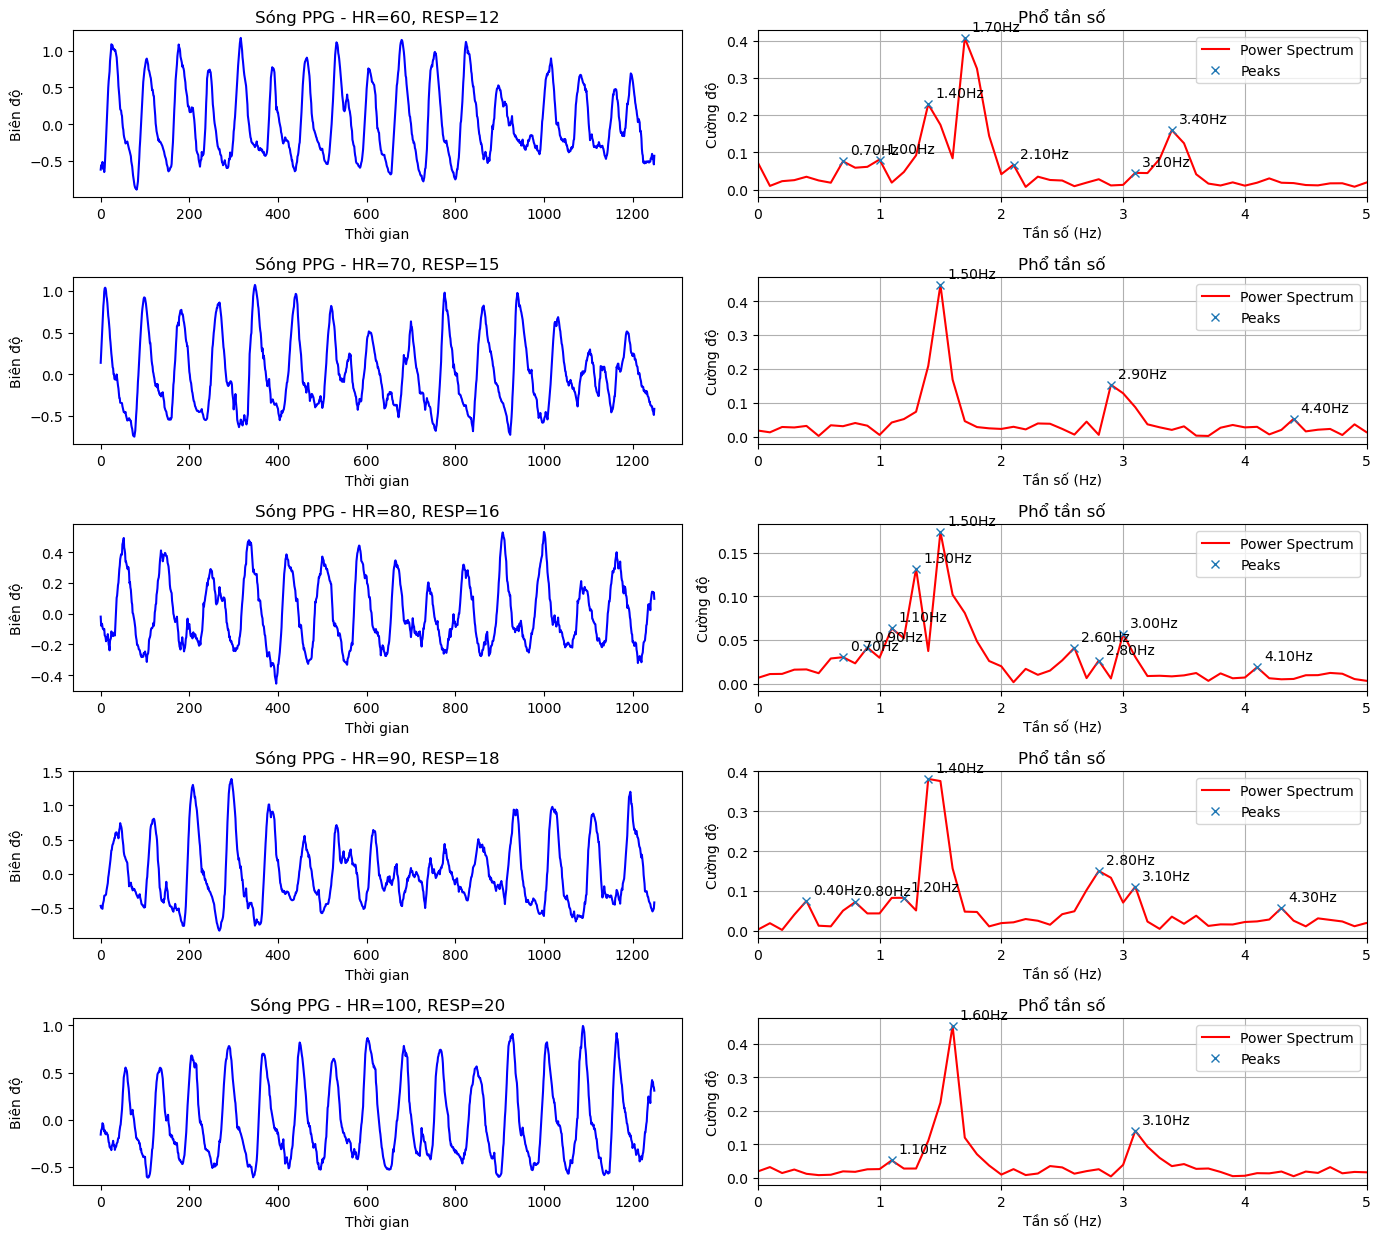

In [22]:
from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq

# Số mẫu PPG muốn tạo
num_generated = 5

# Tạo latent vector ngẫu nhiên
z = torch.randn(num_generated, latent_dim)

# Tạo điều kiện HR và RESP gốc
conditions_generated_raw = np.array([
    [60, 12],
    [70, 15],
    [80, 16],
    [90, 18],
    [100, 20]
])

# Chuẩn hóa giống với conditions
conditions_generated_norm = minmax_scaler.transform(conditions_generated_raw)
conditions_generated_norm = torch.FloatTensor(conditions_generated_norm)

# Tạo PPG mới
cvae_loaded.eval()
with torch.no_grad():
    ppg_generated = cvae_loaded.decoder(z, conditions_generated_norm)

# Thông số FFT
fs = 125  # tần số lấy mẫu
duration = 10

# Tạo lưới biểu đồ 5 hàng, 2 cột
fig, axs = plt.subplots(num_generated, 2, figsize=(14, 2.5 * num_generated))

for i in range(num_generated):
    signal = ppg_generated[i].numpy()
    hr, resp = conditions_generated_raw[i]

    # Biểu đồ sóng (trái)
    axs[i, 0].plot(signal, color='b')
    axs[i, 0].set_title(f'Sóng PPG - HR={hr}, RESP={resp}')
    axs[i, 0].set_xlabel('Thời gian')
    axs[i, 0].set_ylabel('Biên độ')

    # Biểu đồ phổ tần số (phải)
    n = len(signal)
    yf = fft(signal)
    xf = fftfreq(n, 1/fs)[:n//2]
    power_spectrum = 2.0/n * np.abs(yf[0:n//2])
    peaks, _ = find_peaks(power_spectrum, height=np.max(power_spectrum)*0.1)
    peak_freqs = xf[peaks]
    peak_values = power_spectrum[peaks]

    axs[i, 1].plot(xf, power_spectrum, 'r-', label='Power Spectrum')
    axs[i, 1].plot(peak_freqs, peak_values, "x", label='Peaks')
    for freq, val in zip(peak_freqs, peak_values):
        axs[i, 1].annotate(f'{freq:.2f}Hz', (freq, val), xytext=(5, 5), textcoords='offset points')
    axs[i, 1].set_xlim(0, 5)
    axs[i, 1].set_xlabel('Tần số (Hz)')
    axs[i, 1].set_ylabel('Cường độ')
    axs[i, 1].set_title('Phổ tần số')
    axs[i, 1].grid(True)
    axs[i, 1].legend()

plt.tight_layout()
plt.show()
